<a target="_blank" rel="noopener noreferrer" href="https://colab.research.google.com/github/ccaudek/ds4psy_2023/blob/main/420_reglin_ppc.ipynb">![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)</a>

(ppcheck-appendix)=
# Posterior Predictive Checks

I controlli predittivi a posteriori (PPC) rappresentano un ottimo metodo per convalidare un modello. L'idea alla base è quella di generare dati dal modello utilizzando i parametri della distribuzione a posteriori. Questo argomento è stato trattato nel capitolo {ref}`bayesian_prediction_notebook`. È importante ricordare che i PPC mirano a valutare il grado di discrepanza tra i dati generati dal modello e la vera distribuzione $Y$. In altre parole, ciò ci permette di capire se la distribuzione a posteriori ottenuta è simile alla distribuzione teorica dei dati osservati. Nel seguente tutorial, esploreremo come utilizzare gli strumenti grafici offerti da `arviz` per affrontare questo problema.

## Simulazione

Iniziamo a simulare dei dati.

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pymc as pm
from pymc import HalfNormal, Model, Normal, sample
import xarray as xr
from statsmodels.nonparametric.smoothers_lowess import lowess as sm_lowess
import warnings

warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")

print(f"Runing on PyMC v{pm.__version__}")


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Runing on PyMC v5.6.1


In [2]:
# Initialize random number generator
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)

plt.style.use("bmh")
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

sns.set_theme(palette="colorblind")

%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%config InlineBackend.figure_format = "svg"

def standardize(series):
    """Standardize a pandas series"""
    return (series - series.mean()) / series.std()

I dati verranno simulati in modo tale da avere una relazione non lineare tra $X$ e $Y$. 

In [3]:
# Size of dataset
size = 100

x = 2*np.random.random(size)
y = np.sin(x) * 12*np.exp(-x) + np.random.normal(0, 0.2, size)

zx = standardize(x)
zy = standardize(y)


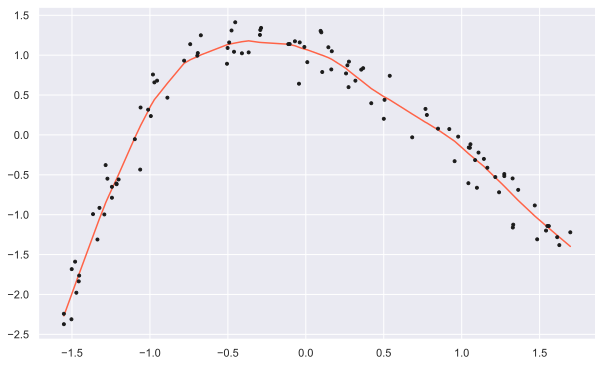

In [4]:
sm_x, sm_y = sm_lowess(zy, zx,  frac=1./5., it=5, return_sorted=True).T
plt.plot(sm_x, sm_y, color='tomato')
plt.plot(zx, zy, 'k.')


È ovvio che, in un caso come questo, un modello lineare come quello che abbiamo esaminato in precedenza, non è adeguato. Ma adattiamo comunque un modello lineare ai dati proprio per verificare se i PPC saranno in grado di mettere in luce il fatto che il modello è sbagliato. Implemento qui lo stesso modello che abbiamo usato in precedenza. I dati sono standardizzati, per cui le seguenti distribuzioni a priori per i parametri sono adeguate.

In [5]:
with pm.Model() as model_0:
    a = pm.Normal("a", 0.0, 2.0)
    b = pm.Normal("b", 0.0, 2.0)

    mu = a + b * zx
    sigma = pm.Normal("sigma", sigma=5.0)

    pm.Normal("obs", mu=mu, sigma=sigma, observed=zy)
    idata_0 = pm.sample()

Auto-assigning NUTS sampler...


Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)


NUTS: [a, b, sigma]


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.


Anche se il modello è sbagliato, i trace plot non mettono in evidenza alcuna anomalia di rilievo.

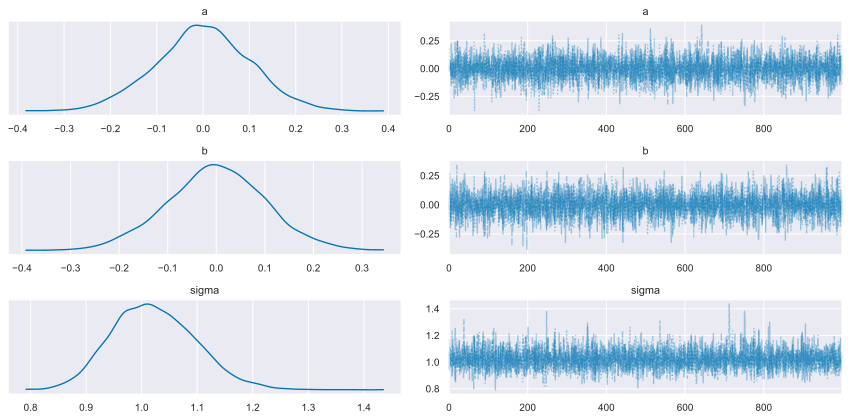

In [6]:
_ = az.plot_trace(idata_0, combined=True)
plt.tight_layout()


Generiamo ora i dati necessari per i controlli predittivi a posteriori. A tal fine, useremo una funzione PyMC dedicata a questo scopo per campionare i dati dalla distribuzione a posteriori. Questa funzione estrarrà casualmente 4000 campioni di parametri dalla traccia. Quindi, per ogni campione, estrarrà 100 numeri casuali da una distribuzione normale specificata dai valori di mu e sigma in quel campione (si veda il capitolo {ref}`bayesian_prediction_notebook`.):

In [7]:
with model_0:
    pm.sample_posterior_predictive(
        idata_0, extend_inferencedata=True, random_seed=rng);

Sampling: [obs]


Ora, l'oggetto `posterior_predictive` in `idata_0` contiene 4000 set di dati simulati, contenenti 100 campioni ciascuno, ognuno dei quali è stato calcolato usando un valore del parametro preso a caso dalla distribuzione a posteriori:

In [8]:
idata_0

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

A questo punto possiamo utilizzare la funzione `az.plot_ppc()` per determinare se il modello è almeno in grado di riprodurre i dati osservati:

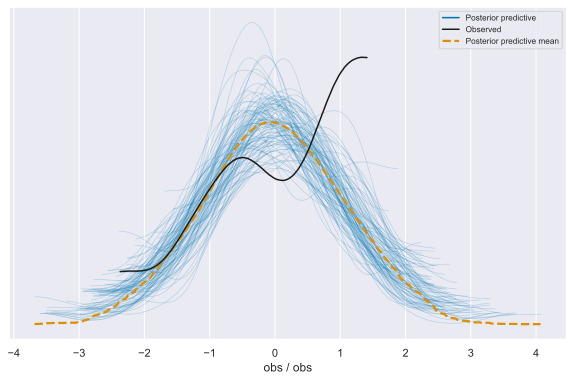

In [9]:
_ = az.plot_ppc(idata_0, num_pp_samples=100)


Il PPC plot mostra come vi sia pochissima corrispondenza tra la distribuzione dei dati osservati (in nero) e la distribuzione dei dati predetti dal modello. Questo era atteso, dato che abbiamo adattato un modello del tutto sbagliato per i dati a disposizione.

Proseguiamo con la simulazione.  I dati sono stati generati con una funzione non lineare.  In generale, quella funzione è sconosciuta. Qualunque funzione non lineare, però, può essere approssimata da un modello polinomiale. Un modello di regressione polinomiale si ottiene inserendo nel modello dei nuovi predittori, ciascuno ottenuto elevando la variabile originale a una potenza:

$$
\mathbb{E}(Y) = \alpha + \beta_1 x + \beta_2 x^2 + \beta_3 x^3 + \beta_4 x^4 + \dots
$$

Questo modello, anche se non descrive una relazione lineare tra $X$ e $Y$, è funzione lineare dei coefficienti ignoti $\alpha, \beta_1, \beta_2, \dots$. Il grado del polinomio dipende dal tipo di curva che vogliamo approssimare.  Proviamo qui con un modello polinomiale di ordine 4.

In [10]:
zx2 = zx**2
zx3 = zx**3
zx4 = zx**4

with pm.Model() as model_1:
    a = pm.Normal("a", 0.0, 3.0)
    b1 = pm.Normal("b1", 0.0, 3.0)
    b2 = pm.Normal("b2", 0.0, 3.0)
    b3 = pm.Normal("b3", 0.0, 3.0)
    b4 = pm.Normal("b4", 0.0, 3.0)
    
    mu = a + b1 * zx + b2 * zx2 + b3 * zx3 + b4 * zx4
    sigma = pm.HalfNormal("sigma", sigma=5.0)

    pm.Normal("obs", mu=mu, sigma=sigma, observed=zy)
    idata_1 = pm.sample()


Auto-assigning NUTS sampler...


Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)


NUTS: [a, b1, b2, b3, b4, sigma]


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.


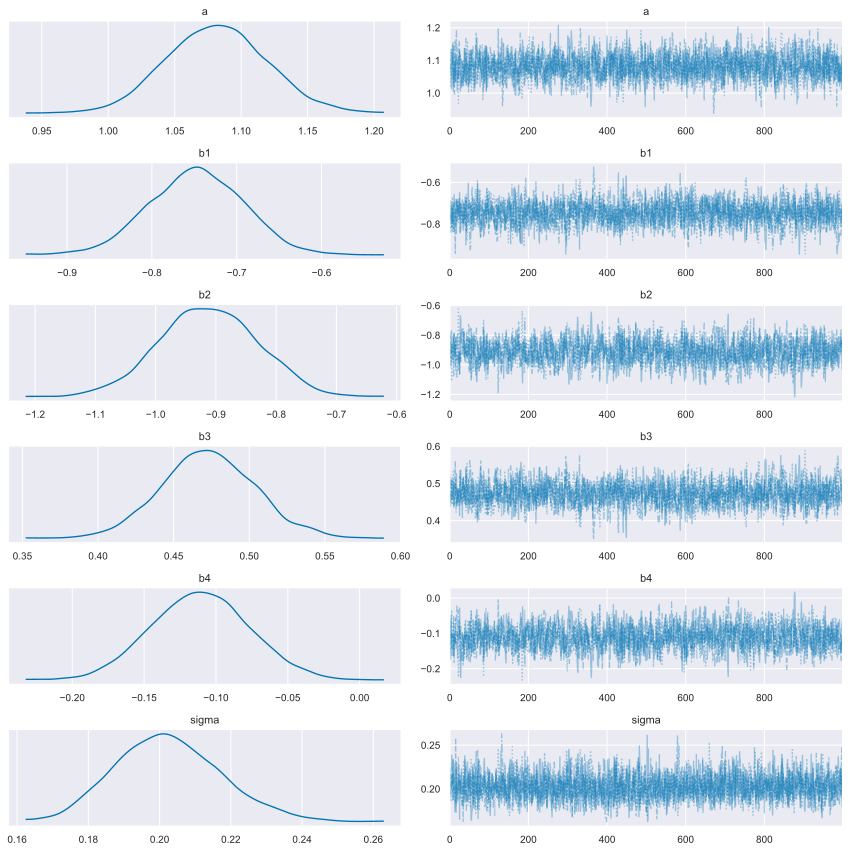

In [11]:
_ = az.plot_trace(idata_1, combined=True)
plt.tight_layout()


In [12]:
az.summary(idata_1)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,1.081,0.038,1.005,1.146,0.001,0.001,2190.0,2399.0,1.0
b1,-0.748,0.056,-0.850,-0.643,0.001,0.001,1663.0,1739.0,1.0
b2,-0.912,0.081,-1.062,-0.763,0.002,0.001,1558.0,2009.0,1.0
b3,0.473,0.031,0.416,0.534,0.001,0.001,1727.0,2059.0,1.0
b4,-0.111,0.034,-0.176,-0.049,0.001,0.001,1632.0,2205.0,1.0
sigma,0.202,0.015,0.176,0.231,0.000,0.000,3009.0,2558.0,1.0


Anche in questo caso, campioniamo dalla distribuzione a posteriori dei parametri e simuliamo i dati possibili futuri. L'esame del PPC plot, in questo secondo caso, mostra una buona corrispondenza tra le predizioni del modello e i dati osservati.

Sampling: [obs]


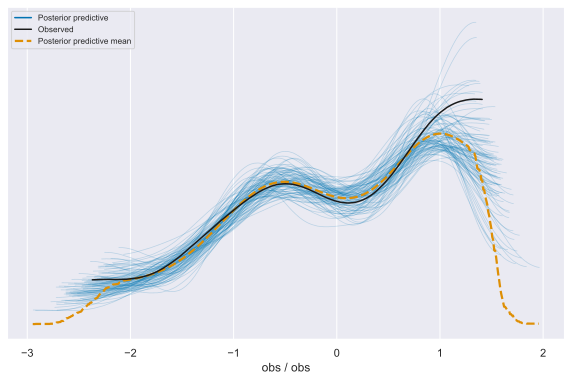

In [13]:
with model_1:
    pm.sample_posterior_predictive(
        idata_1, extend_inferencedata=True, random_seed=rng)

_ = az.plot_ppc(idata_1, num_pp_samples=100)


Si noti che la curva nera rappresenta la distribuzione della variabile dipendente, come risulta anche dal seguente KDE plot.

<Axes: ylabel='Density'>

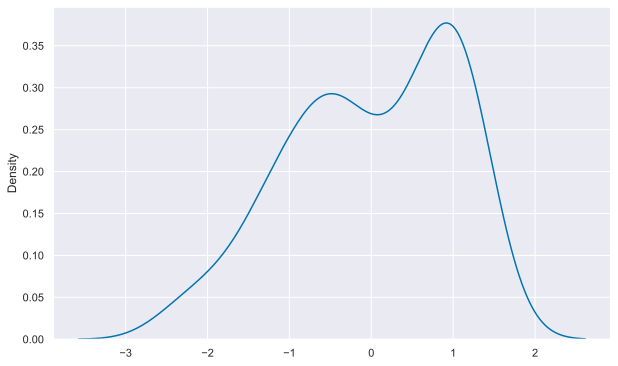

In [14]:
sns.kdeplot(zy)

Poniamoci ora il problema di generare un grafico che mostra la relazione prevista tra il predittore ($x$) e i valori della $y$ previsti dal modello. 

Sampling: [obs]


Text(0, 0.5, 'Outcome (stdz)')

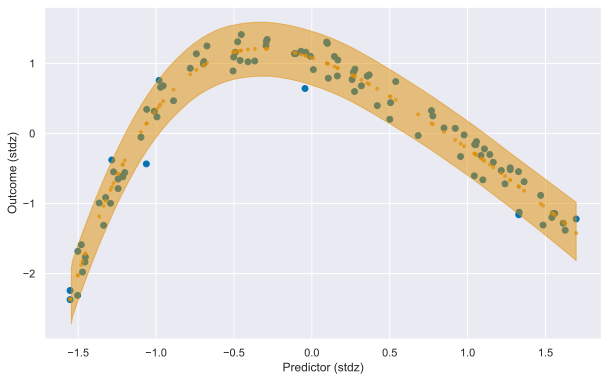

In [15]:
with model_1:
    pm.sample_posterior_predictive(
        idata_1, extend_inferencedata=True, random_seed=rng)

post = idata_1.posterior
mu_pp = post["a"] + post["b1"] * xr.DataArray(zx, dims=["obs_id"]) + \
    post["b2"] * xr.DataArray(zx2, dims=["obs_id"]) + \
    post["b3"] * xr.DataArray(zx3, dims=["obs_id"]) + \
    post["b4"] * xr.DataArray(zx4, dims=["obs_id"]) 

_, ax = plt.subplots()

ax.plot(
    zx, mu_pp.mean(("chain", "draw")), '.', label="Mean outcome", color="C1", alpha=0.6
)
ax.scatter(zx, idata_1.observed_data["obs"])
az.plot_hdi(zx, idata_1.posterior_predictive["obs"])

ax.set_xlabel("Predictor (stdz)")
ax.set_ylabel("Outcome (stdz)")


per questo secondo modello vediamo come i dati predetti (la banda evidenziata) approssimano da vicino la relazione tra i dati osservati e la $x$.

Ripetiamo questo procedimento usando i dati del modello sbagliato.

Sampling: [obs]


Text(0, 0.5, 'Outcome (stdz)')

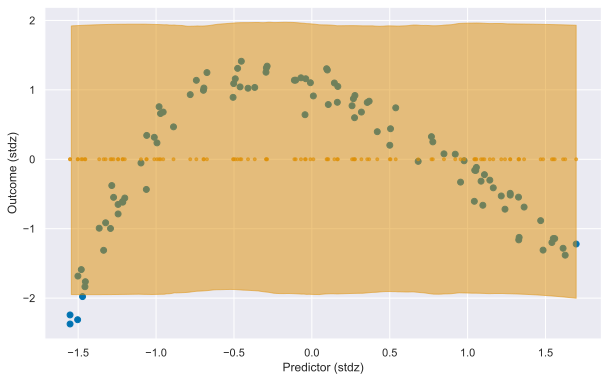

In [16]:
with model_0:
    pm.sample_posterior_predictive(
        idata_0, extend_inferencedata=True, random_seed=rng)

post = idata_0.posterior
mu_pp = post["a"] + post["b"] * xr.DataArray(zx, dims=["obs_id"]) 

_, ax = plt.subplots()

ax.plot(
    zx, mu_pp.mean(("chain", "draw")), '.', label="Mean outcome", color="C1", alpha=0.6
)
ax.scatter(zx, idata_0.observed_data["obs"])
az.plot_hdi(zx, idata_0.posterior_predictive["obs"])

ax.set_xlabel("Predictor (stdz)")
ax.set_ylabel("Outcome (stdz)")


Si noti come, in questo caso, vi è un'enorme incertezza nella predizone del modello. E, ovviamente, i dati predetti non rendono conto, in nessun modo, della relazione tra i valori osservati $x, y$.

In conlusione, dunque, i PPC plot sono un'utile strumento per il confronto tra modelli.

## Watermark

In [17]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Sun Sep 17 2023

Python implementation: CPython
Python version       : 3.11.5
IPython version      : 8.15.0

numpy     : 1.25.2
pymc      : 5.6.1
matplotlib: 3.7.2
arviz     : 0.16.0
xarray    : 2023.6.0
seaborn   : 0.12.2

Watermark: 2.4.3

